In [ ]:
import transformers
import matplotlib.pyplot as plt
import torch
from transformers.models.clip.modeling_clip import CLIPModel
from transformers.models.clip.processing_clip import CLIPProcessor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


device = "mps"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
import os
def get_number_prefix(filename):
    # Split the filename by non-digit characters
    parts = ''.join(filter(str.isdigit, filename))
    # Convert the extracted digits to an integer
    return int(parts) if parts else 0

def get_sorted_files(directory):
    # Get a list of all files in the directory
    files = os.listdir(directory)
    # Sort the files based on the number prefix using the custom key function
    sorted_files = sorted(files, key=get_number_prefix)
    return sorted_files

def clip_encode_image(image_path):
    # Load the image
    img = Image.open(image_path)
    image = preprocess(images=[img], return_tensors="pt", padding=True)
    image = {k: v.to(device) for k, v in image.items()}
    
    with torch.no_grad():
        image_features = model.get_image_features(**image)
    
    return image_features

def calculate_clip_distance(image_path1, image_path2):
    # Load the images
    image_features1 = clip_encode_image(image_path1)
    image_features2 = clip_encode_image(image_path2)
    
    # Normalize the features
    image_features1 = image_features1 / image_features1.norm(dim=-1, keepdim=True)
    image_features2 = image_features2 / image_features2.norm(dim=-1, keepdim=True)
    
    # Calculate the distance (cosine similarity)
    distance = 1 - torch.nn.functional.cosine_similarity(image_features1, image_features2)
    
    return distance.item()

sample_dirs = ['samples/samples_15', 'samples/samples_15_lq', 'samples/samples_mq', 'samples/samples_xl_lq', 'samples/samples_xl_lq_high_cfg']
sample_dir_files = [get_sorted_files(d) for d in sample_dirs]

common_files = list(set(sample_dir_files[0]).intersection(*sample_dir_files))

distances = []

for i, file in enumerate(common_files):
    baseline_file = f'{sample_dirs[0]}/{file}'
    distances_for_file = []
    for j, sample_dir in enumerate(sample_dirs[1:]):
        sample_file = f'{sample_dir}/{file}'
        distance = calculate_clip_distance(baseline_file, sample_file)
        print(f'{i+1} {j+1} {file} {distance}')
        distances_for_file.append(distance)
    distances.append(distances_for_file)

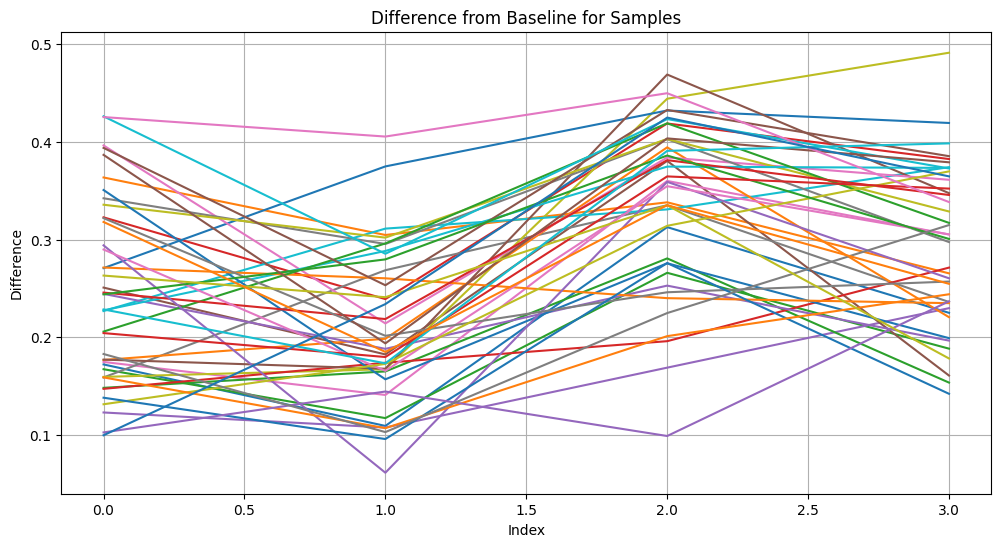

In [20]:
sample_values = np.array(distances)

# Calculate differences between baseline and sample values for each sample

# Plotting
plt.figure(figsize=(12, 6))
for i in range(len(distances)):
    plt.plot(distances[i], label=f'Sample {i+1}')

plt.title('Difference from Baseline for Samples')
plt.xlabel('Index')
plt.ylabel('Difference')
plt.grid(True)
plt.show()
